# Data Scientist Nanodegree
Ravi Dayabhai, April 2019
## Supervised Learning Project: Finding Donors for *CharityML*

Welcome to the first project of the Data Scientist Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** This notebook runs on Python 3.6.7, SciKit-Learn 0.20.3.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**HINT:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data['income'].value_counts().loc['>50K']

# Number of records where individual's income is at most $50,000
n_at_most_50k = data['income'].value_counts().loc['<=50K']

# Percentage of individuals whose income is more than $50,000
greater_percent = 100 * n_greater_50k / n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


### Feature Set Exploration

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

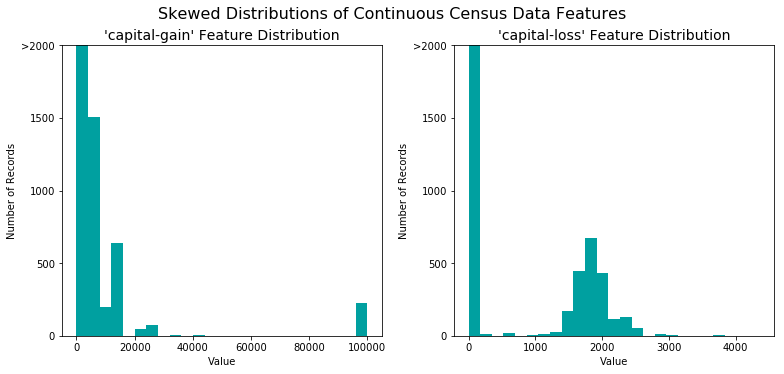

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

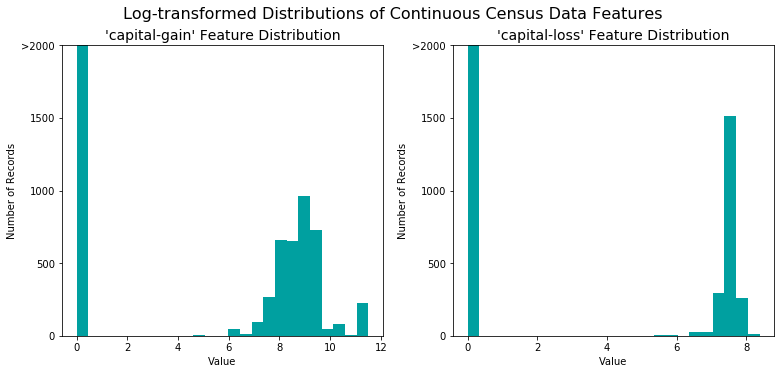

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

//anaconda/envs/DSND/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

| i  | someFeature |
| :-: | :-: |
| 0 |  B  | 
| 1 |  C  | 
| 2 |  A  | 


|i | someFeature_A | someFeature_B | someFeature_C
| :-: | :-: | :-: | :-: |
| 0 | 0 | 1 | 0 |
| 1 | 0 | 0 | 1 |
| 2 | 1 | 0 | 0 |


Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 1 if x == ">50K" else 0)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print(encoded)

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \\$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \\$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \\$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \\$50,000, and those who make more), it's clear most individuals do not make more than \\$50,000. 

This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives (all words classified as spam, irrespective of whether that was the correct classification), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

**Recall (sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam. It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average (harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score (we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

_Note_: The purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

In [8]:
# Import scoring metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score

# Naive model predicts always >$50k salary
naive_y_pred = np.ones(len(y_test))

# Calculate accuracy, precision and recall
accuracy = accuracy_score(y_test, naive_y_pred)
recall = recall_score(y_test, naive_y_pred)
precision = precision_score(y_test, naive_y_pred)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = fbeta_score(y_test, naive_y_pred, beta=0.5)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2438, F-score: 0.2872]


_ANSWER_:

A naïve predictor (i.e., all individuals classified as earning \$50k+) has an accuracy of 24%, which is the incidence of positive targets in this test set. The F-score, which is biased toward _precision_, is very poor as a consequence (0.28).


* When we have a model that always predicts '1' (i.e., the individual makes more than \\$50k) then our model will have no True Negatives (TN) or False Negatives (FN) as we are not making any negative ('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision `(True Positives/(True Positives + False Positives))` as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score `(True Positives/(True Positives + False Negatives))` in this setting becomes 1 as we have no False Negatives.

###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the Census data.

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

_ANSWER_:

#### Model 1: Gaussian Naive Bayes

Naïve Bayes ("NB") models have demonstrated their usefulness in other natural language processing (NLP) applications: sentiment analysis (e.g., identifying on social media positive or negative trends), categorization (e.g., is this text business, sports or neither?), or, as we've seen, email spam detection. 

The model is generally very fast to train and doesn't require a ton of hyperparameter optimization. Additionally, it tends not to overfit because it is relatively high bias[1]. The speed and high bias nature of NB is because of its simplicity: the algorithm explicitly calculates its parameters from the data rather than converging on them using an optimization technique like gradient descent. However, this simplicity -- it produces a linear hypothesis function -- cuts the other way when the data exhibits any non-linear complexity.

This seems like an ideal data set for naive Bayes given the limited number of features (a NB approach fails to capture feature-on-feature interaction given its independence assumption) and the small data set (NB doesn't need a ton of data to fit).


#### Model 2: Logistic Regression

Logistic regression is another well-studied model used in the real-world for applications like default risk assessment (e.g., "Should we issue a credit card to an applicant like this?")[2] or mortality of injured patients[3]. Despite its name, it can perform classification (the task at hand here) and basically takes an input and maps it to a logit function that squishes down the log-odds transformed linear model using a sigmoid function whose output produces a log-odds estimate of how likely the given data point is "positive" or not for some threshold probability, often 0.5. The linear model (pre-squishing is determined via maximum likelihood estimation rather than something like least squares minimization).

Logistic regression models are useful because they are easy to interpret; said another way, the relationship between features and the outcome are made explicit and we can answer questions about relative importance of features and interactions among the features. Regularization can help prevent overfitting. Logistic regression, however, also makes a set of assumptions[4] that might limit its appropriateness, especially regarding multi-collinearity in this case (e.g., `education` and `education-`num` are highly, highly correlated). 

With smart feature selection, logistic regression seems to be a decent candidate for this data set given the binary classification task and the absence of obvious and very polar outliers (a potential pitfall of using logistic regression blindly).


#### Model 3: Ensemble Methods - AdaBoost

AdaBoost differs from the first two algorithms in that it is an _ensemble method_, which means it is a machine learning algorithm that uses _other_ machine learning algorithms! I explain the nuts and bolts of it more below, but know that it's pretty powerful having been used for facial recognition[6] and to detect pedestrians[7].

These ensemble methods have proven themselves to be quite good predictors, drawing inspiration from the "wisdom of crowds" (where, in this instance, the crowd is comprised of indepedent sub-classifiers!). 

The most obvious drawback of boosting is the computational complexity. Performing so many iterations, and generating a new model at each, requires a lot of computations and time (and also space). The fact that the ensemble has to be built iteratively doesn’t help matters. However, using simple weak learners (instead of big decision trees) helps to mitigate this problem.[8]

This seems like a manageable use case for AdaBoost since the simplicity of the data mitigates the complexity of the model. 

---

[1]: https://www.quora.com/Why-is-Naive-Bayes-considered-to-be-a-high-bias-low-variance-classifier-Why-does-it-converge-faster-than-logistic-regression "Why is Naive Bayes considered to be a high bias/low variance classifier? Why does it converge faster than logistic regression?"

[2]: https://www.kaggle.com/uciml/german-credit/data "Kaggle: German Credit Risk"

[3]: https://en.wikipedia.org/wiki/Logistic_regression#Logistic_regression_vs._other_approaches "Logistic Regression (Wikipedia)"

[4]: https://www.lexjansen.com/wuss/2018/130_Final_Paper_PDF.pdf "Logistic and Linear Regression Assumptions: Violation Recognition and Control (Schreiber-Gregory 2018)"

[5]: https://elitedatascience.com/machine-learning-algorithms#classification "Modern Machine Learning Algorithms: Strengths and Weaknesses"

[6]: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.407.7784&rep=rep1&type=pdf "AdaBoost-based face detection for embedded systems (Yang et. al. 2010)"

[7]: http://users.cecs.anu.edu.au/~wanglei/SPR_course/boosting.pdf "Boosting: Algorithms and Applications, ANU 2008"

[8]: https://codesachin.wordpress.com/tag/adaboost/ "A (small) introduction to Boosting"

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set (X_test), then get predictions on the first 300 training samples (X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


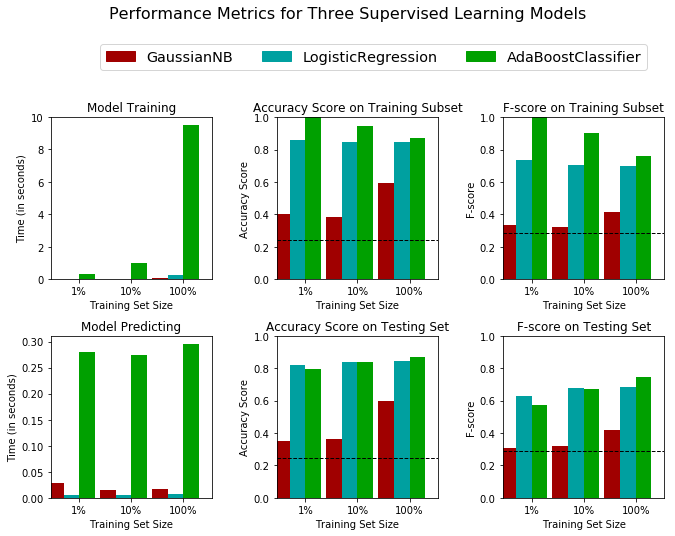

In [10]:
# Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Initialize the three models
clf_A = GaussianNB()
clf_B = LogisticRegression(solver='liblinear', random_state=11)
clf_C = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=200, random_state=11)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(.10 * len(y_train))
samples_1 = int(.01 * len(y_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one (hyper)parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

_ANSWER_:


I believe that **AdaBoost** is the best algorithm (among the three identified) for this binary classification task. This algorithm performs better than Gaussian Naive Bayes and Logistic Regression when 1) measured by accuracy or F-score and 2) allowed to train on the full training set. It really was a two-horse race between logistic regression and AdaBoost since there was a gulf between these two methods and the naive Bayes approach at all sizes of training data. It is worth mentioning that logistic regression holds its own at smaller training data set sizes, but AdaBoost prevails when all available training data are used. 

Even though the training time, on a relative basis, is substantially longer (AdaBoost takes about 10 seconds to train vs. the other two algorithms at less than 2 seconds each), the size of this data set (thousands of records, 13 features) and compute power available favors the performance benefit. I think the dearth of features and tractable size of data favors an ensemble method like AdaBoost since the absolute difference in compute/time is minimal.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

_ANSWER_: 


AdaBoost, for classification, is a "meta"-algorithm in that it capitalizes on the implicit learning that happens when the following process is repeated a number of times:

  1. A weak learner (itself a classifier, such as a decision tree) is fit to the data\*.
  2. The errors (read: incorrect classifications) are calculated and the mischaracterized data points are given  a little more importance and the correct data points are given slightly less importance for the next iteration of this loop. Note that the change in importance assigned to each data point (in either direction, increase in importance or decrease) depends on a _learning step_ that is inversely proportional to the error of the weak learner.[1]
  3. This learning step is the weight associated with the weak model. 
  4. Repeat.
  
After the above is completed a specified number of times, all of the weak learners "vote" -- mathematically, this is the weighted average of the weak models. (Notice that the models with "more votes" (read: higher weights) are those that demonstrated smaller errors.) The final model produced is the model that reflects this "voting."

---
\*_Note_: Initially, the data is equally-weighted. The weights are updated during every iteration of the aforementioned process and the updated distribution of weights is used in Step #1, so each weak learner is learning on a the same data set, but each point in the data set is weighted differently from learner to learner. 


[1]: https://cseweb.ucsd.edu/~yfreund/papers/IntroToBoosting.pdf "A Short Introduction to Boosting: AdaBoost"

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [11]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = AdaBoostClassifier(DecisionTreeClassifier(), random_state=11)

# Create the parameters list you wish to tune, using a dictionary if needed
parameters = dict(base_estimator__max_depth=[1,2,4], n_estimators=[50, 100, 500])

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer, cv=3)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8273
F-score on testing data: 0.6460

Optimized Model
------
Final accuracy score on the testing data: 0.8664
Final F-score on the testing data: 0.7432


The following details the best estimator (optimized model):

In [12]:
print(best_clf)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=500, random_state=11)


### Question 5 - Final Model Evaluation

#### Results:

|     Metric     |   Naïve Model   | Unoptimized Model | Optimized Model |
| :------------: | :--------------:| :---------------: | :-------------: | 
| Accuracy Score | 24.38% | 82.73% | 86.64% |
| F-score        | 28.72% | 64.60% | 74.32% |


* What is your optimized model's accuracy and F-score on the testing data?

_ANSWER_:

The optimized model's accuracy and F-scores ($\beta =0.5$, to make precision more important in the harmonic mean calculation) are 0.8664 and 0.7432; the table above shows a comparison of results (in percentage terms).

* Are these scores better or worse than the unoptimized model? 

_ANSWER_:

The optimized model is about 3 percentage points more accurate than the unoptimized model, but the lift to the F-score is +8 percentage points better versus the unoptimized model.

* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?  

_ANSWER_:

The table above shows that the optimized model is worlds better than the naïve, always-positive classifier: on both accuracy and F-beta metrics, the optimized model scores 3-4x higher.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen features, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

_ANSWER_:

Many of these are motivated from the very quick-and-dirty EDA steps performed below (e.g., correlation matrix among numerical fields) combined with my own hunches of what drives salaries.

1. **Capital Gains** (`capital-gain`): This seems like the most telling feature, given that investment is, generally, the preserve of those who earn in excess of some threshold of consumption. This notional threshold implies a natural separation of those that have relatively more earnings power versus those with relatively less. 

2. **Education** (`education-num`): As someone who works in education (Khan Academy!), this strikes me as the second clearest distinguishing factor of salaries: more education  correlates to higher incomes. 

3. **Occupation** (`working class`): I suspect that the particular occupation someone has significantly impacts their income, more than age alone. For example, I can imagine that even younger workers in high-earning occupations will have bigger incomes than older workers in low-income jobs. 

4. **Age** (`age`): Earnings roughly increase as a function of time; human capital is translated into financial capital as people gain more experience as their careers progress. However, I think that differences in education stratify the population enough such that it is generally not the case that someone whose education is one or two levels below another's person will command a higher salary despite age (or years worked).

5. **Relationship** (`relationship`): This variable is a little cryptic but a little digging suggests this is meant to capture roles within a given household surveyed in the Census. This seems to vary quite a bit by category, which makes sense given "Own-children" are very unlikely breadwinners. This also seems to capture marriage dynamics which is also intriguing.

#### Feature Relationships Exploration

This section is simply me poking around to see if there are any obvious relationships in the data that might help with the classification task and to give me a feel for which features show a lot of variance in the binary classification of incomes.

In [13]:
# Assemble the transformed data and labels
df_eda = features_log_minmax_transform.copy()
df_eda['income'] = income

# Correlation matrix among numerical fields 
df_eda.corr()

,age,education-num,capital-gain,capital-loss,hours-per-week,income
age,1.000000,0.037623,0.122068,0.055331,0.101992,0.237040
education-num,0.037623,1.000000,0.129347,0.078967,0.146206,0.332800
capital-gain,0.122068,0.129347,1.000000,-0.066899,0.086098,0.287740
capital-loss,0.055331,0.078967,-0.066899,1.000000,0.051587,0.139253
hours-per-week,0.101992,0.146206,0.086098,0.051587,1.000000,0.227199
income,0.237040,0.332800,0.287740,0.139253,0.227199,1.000000


Then to quickly get a sense of what's going on with the non-numeric type data, I construct a dictionary of DataFrames that break down the proportion of people with incomes below and above (or equal to) $50k by the categories within each field.

The example below of the `relationship` feature shows the _row-wise_ percentage distribution  between the two target variable categories. Calculating the variance _by column_ then tells me how varied these categories are -- the more varied, the more likely this feature can tell me something about people's incomes.

In [14]:
# Isolate non-numeric data
df_eda_categorical = df_eda.select_dtypes(include=['object']).copy()
df_eda_categorical = df_eda_categorical.join(df_eda['income'])

# Looking at incidence of high-earnings individuals based on non-numerical groupings
cat_comp_dict = {}
for category in df_eda_categorical.columns[:-1]:
    df_counts = df_eda_categorical.pivot_table(index=[category], columns=['income'], aggfunc='count', margins=True).iloc[:,0:3]
    df_counts.columns = df_counts.columns.droplevel(0)
    cat_comp_dict[category] = df_counts.div(df_counts['All'], axis='index').iloc[:-1:]

cat_comp_dict['relationship']

income,0,1,All
relationship,,,
Husband,0.544252,0.455748,1.0
Not-in-family,0.895061,0.104939,1.0
Other-relative,0.962936,0.037064,1.0
Own-child,0.984153,0.015847,1.0
Unmarried,0.936926,0.063074,1.0
Wife,0.514108,0.485892,1.0


In [15]:
for k, v in cat_comp_dict.items():
    print("{}: variance of percentage income splits = {:.2f}".format(k, v.var()[0]))

workclass: variance of percentage income splits = 0.02
education_level: variance of percentage income splits = 0.06
marital-status: variance of percentage income splits = 0.03
occupation: variance of percentage income splits = 0.02
relationship: variance of percentage income splits = 0.05
race: variance of percentage income splits = 0.01
sex: variance of percentage income splits = 0.02
native-country: variance of percentage income splits = 0.02


### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

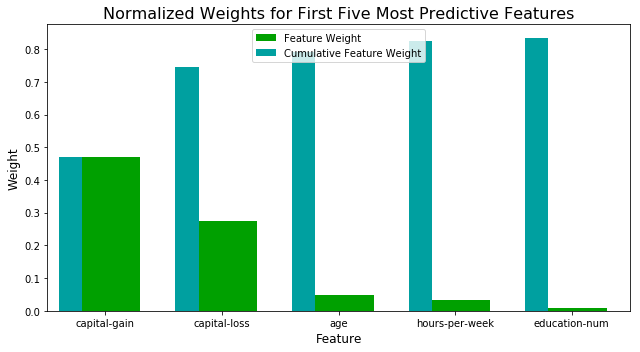

In [16]:
# Note: Using the AdaBoostClassifier from above to extract important features

# Extract the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  

* How do these five features compare to the five features you discussed in **Question 6**?

_ANSWER_:

My intuition was correct regarding capital gains, age, and education. However, I'm surprised to see capital losses and hours worked per week appear as top 5 most predictive features in this AdaBoost model.

* If you were close to the same answer, how does this visualization confirm your thoughts?  * If you were not close, why do you think these features are more relevant?

_ANSWERS_:

My thoughts are confirmed that capital gains suggesting that those with investments generating said returns will have higher earnings. What I find bemusing is capital losses, which might suggest that not just making money from investment matters -- just having investments (even to lose!) in the first place is what matters!

Age and education both appeared as relevant features which confirms my thinking that both are important to consider in this classification problem, but the order of their importances surprises me. This would, if given more information and time, want to dig into the data a bit more to understand if my hypothesis that education tends to trump age as a predictor of salary is wholly incorrect or perhaps is a function of something else (e.g., in one's early-career on education matters more, but later in life age (and commensurate experience) prevails).

Finally, hours worked per week makes sense if the differences in hourly rates between jobs generally isn't so egregiously unequal (read: not super polar). This, at least intuitively, checks out for me given that the separation is at $50k annual income. If this was higher, for example, then I would expect this to become less relevant since 1) there is a natural limit to how much a person can work and 2) hourly wages [possibly proxied by occupation] would need become more varied (to explain high earners vs. low earners).

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [17]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8664
F-score on testing data: 0.7432

Final Model trained on reduced data
------
Accuracy on testing data: 0.8426
F-score on testing data: 0.7044


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?

_ANSWER_: 

The scores are both marginally worse, but this should be expected since the addition of new features will always help explain more variance -- the key is to understand where the "right" tradeoff is in terms of performance, context, and proper fit of the model (e.g., Does the increase in accuracy really reflect better predictions of the underlying data-generating process or are we fitting to noise or measurement error in the data?).

* If training time was a factor, would you consider using the reduced data as your training set?

_ANSWER_: 

If the context (read: limited compute time) called for a model that needed to be trained quickly and to produce predictions quickly, I think prudent feature selection is warranted. In our case, there is minimal loss in performance (i.e., -2 percentage points and -4 percentage points difference between the models constructed with the full feature and limited feature sets), so trading off a little performance for speed is fine absent knowledge about the business context. For the sake of argument, the recommendation would be different if this problem called for only a single, well-optimized model by which to make predictions and if the cost (e.g., wasted labor pursuing false positives) is relatively high, then the tradeoff may not be worth it.